# Exercise 11 - CNN Architectures (Applied)

In [47]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import seaborn as sns

Defining the transformation to tensors and normalization pipeline

In [3]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean, std for grayscale images
])

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # for RGB images
])

### MNIST Dataset

In [4]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


### Fashion MNIST Dataset

In [5]:
fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_mnist)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_mnist)

fashion_train_loader = DataLoader(fashion_train, batch_size=64, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.75MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 68.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.5MB/s]


### CIFAR-10 Dataset

In [6]:
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

cifar_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [8]:
len(fashion_train), len(fashion_test)

(60000, 10000)

In [9]:
len(cifar_train), len(cifar_test)

(50000, 10000)

In [10]:
def show_image(image_tensor, title):
    img = image_tensor.squeeze()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow((img.permute(1, 2, 0) + 1) / 2)  # de-normalize RGB
    plt.title(title)
    plt.axis('off')
    plt.show()


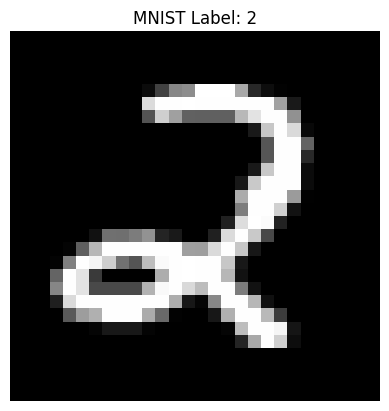

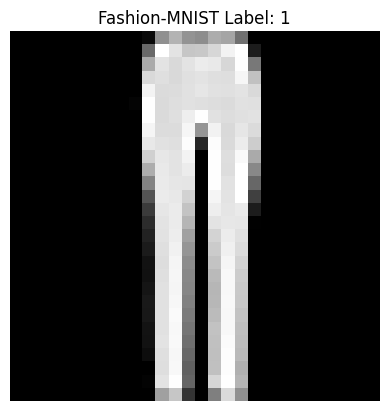

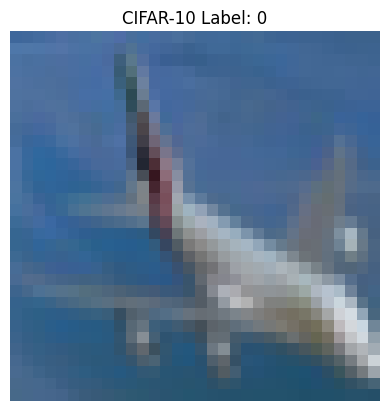

In [11]:
mnist_images, mnist_labels = next(iter(mnist_train_loader))
fashion_images, fashion_labels = next(iter(fashion_train_loader))
cifar_images, cifar_labels = next(iter(cifar_train_loader))

# Show one image from each dataset
show_image(mnist_images[0], f"MNIST Label: {mnist_labels[0].item()}")
show_image(fashion_images[0], f"Fashion-MNIST Label: {fashion_labels[0].item()}")
show_image(cifar_images[0], f"CIFAR-10 Label: {cifar_labels[0].item()}")

### Next let me define the models I am gonna use :

### **LeNet**

In [32]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        # We won't hardcode fc input size, we’ll detect it at runtime
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        self.num_classes = num_classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten

        # initialize FC layers dynamically
        if self.fc1 is None:
            n_features = x.size(1)
            self.fc1 = nn.Linear(n_features, 120).to(x.device)
            self.fc2 = nn.Linear(120, 84).to(x.device)
            self.fc3 = nn.Linear(84, self.num_classes).to(x.device)

        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


### **AlexNet**

In [41]:
def get_alexnet(num_classes=10, in_channels=3, input_size=32):
    layers = []
    # Adjust kernel and stride for smaller images
    if input_size >= 64:
        layers.append(nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))
    else:
        # for small images like 28x28
        layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    layers += [
        nn.Conv2d(64, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten()
    ]

    # Calculate flattened size for given input size
    with torch.no_grad():
        dummy = torch.zeros(1, in_channels, input_size, input_size)
        x = nn.Sequential(*layers[:-1])(dummy)
        flattened_size = x.view(1, -1).size(1)

    classifier = nn.Sequential(
        nn.Linear(flattened_size, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )

    return nn.Sequential(*layers, classifier)

### **ResNet**

In [34]:
def get_resnet(layers=18, num_classes=10, in_channels=3):
    if layers == 18:
        model = models.resnet18(weights=None)
    elif layers == 34:
        model = models.resnet34(weights=None)
    else:
        raise ValueError("Only ResNet-18 or ResNet-34 supported")

    if in_channels != 3:
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


## 📊 Dataset Summary

| Dataset Name       | Input Image Size | Input Channels | Number of Classes | Type of Images                       |
|--------------------|------------------|----------------|-------------------|--------------------------------------|
| **MNIST**          | 28 × 28          | **1** (Grayscale) | **10** | Handwritten digits (0–9)             |
| **Fashion-MNIST**  | 28 × 28          | **1** (Grayscale) | **10** | Clothing items (T-shirt, Dress, Shoe, etc.) |
| **CIFAR-10**       | 32 × 32          | **3** (RGB) | **10** | Real-world objects (Airplane, Dog, Car, etc.) |


In [42]:
# MNIST (1-channel, 28x28)
lenet_mnist = LeNet(in_channels=1, num_classes=10)
alexnet_mnist = get_alexnet(num_classes=10, in_channels=1, input_size=28)
resnet_mnist = get_resnet(18, num_classes=10, in_channels=1)

# CIFAR-10 (3-channel, 32x32)
lenet_cifar = LeNet(in_channels=3, num_classes=10)
alexnet_cifar = get_alexnet(num_classes=10, in_channels=3, input_size=32)
resnet_cifar = get_resnet(34, num_classes=10, in_channels=3)


In [39]:
def train_and_evaluate(model, train_loader, test_loader, dataset_name, model_name, num_epochs=5, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"{model_name} on {dataset_name} [Epoch {epoch+1}/{num_epochs}]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"{model_name} on {dataset_name} | Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

[MNIST] Epoch 1/10 - Loss: 0.0166 - Test Accuracy: 98.65%


[MNIST] Epoch 2/10 - Loss: 0.0157 - Test Accuracy: 98.28%


[MNIST] Epoch 3/10 - Loss: 0.0120 - Test Accuracy: 98.64%


[MNIST] Epoch 4/10 - Loss: 0.0097 - Test Accuracy: 98.34%


[MNIST] Epoch 5/10 - Loss: 0.0106 - Test Accuracy: 98.77%


[MNIST] Epoch 6/10 - Loss: 0.0103 - Test Accuracy: 98.43%


[MNIST] Epoch 7/10 - Loss: 0.0087 - Test Accuracy: 98.78%


[MNIST] Epoch 8/10 - Loss: 0.0098 - Test Accuracy: 98.62%


[MNIST] Epoch 9/10 - Loss: 0.0096 - Test Accuracy: 98.55%


[MNIST] Epoch 10/10 - Loss: 0.0058 - Test Accuracy: 98.76%


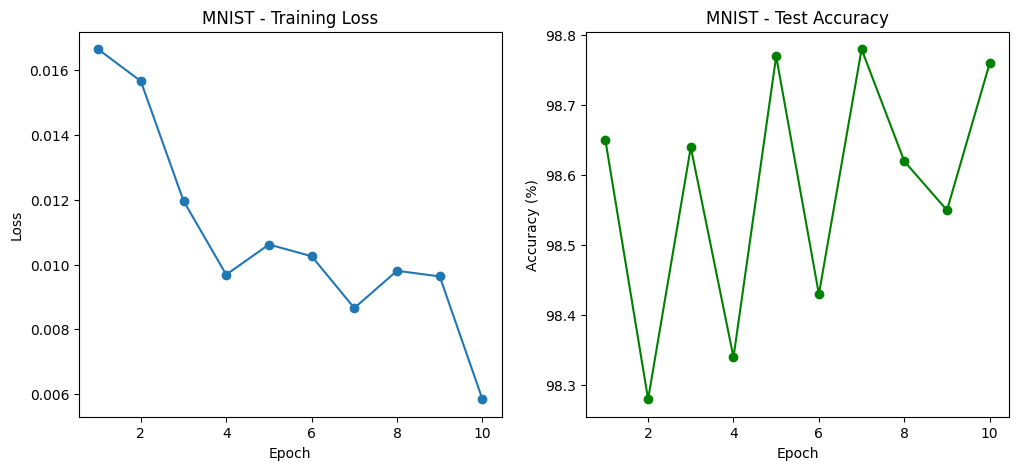

In [25]:
trained_lenet, losses, accuracies = train_and_evaluate(
    model=lenet_mnist,
    train_loader=mnist_train_loader,
    test_loader=mnist_test_loader,
    dataset_name="MNIST",
    num_epochs=10,
    lr=0.001
)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [44]:
models_dict = {
    "LeNet": {
        "MNIST": LeNet(num_classes=10, in_channels=1),
        "FashionMNIST": LeNet(num_classes=10, in_channels=1),
        "CIFAR10": LeNet(num_classes=10, in_channels=3)
    },
    "AlexNet": {
        "MNIST": get_alexnet(num_classes=10, in_channels=1, input_size=28),
        "FashionMNIST": get_alexnet(num_classes=10, in_channels=1, input_size=28),
        "CIFAR10": get_alexnet(num_classes=10, in_channels=3, input_size=32)
    },
    "ResNet": {
        "MNIST": get_resnet(18, num_classes=10, in_channels=1),
        "FashionMNIST": get_resnet(18, num_classes=10, in_channels=1),
        "CIFAR10": get_resnet(18, num_classes=10, in_channels=3)
    }
}

# Dataset loaders dictionary (unchanged)
datasets_dict = {
    "MNIST": (mnist_train_loader, mnist_test_loader),
    "FashionMNIST": (fashion_train_loader, fashion_test_loader),
    "CIFAR10": (cifar_train_loader, cifar_test_loader)
}


In [45]:
results = []

for model_name, dataset_map in models_dict.items():
    for dataset_name, model in dataset_map.items():
        print(f"\n🚀 Training {model_name} on {dataset_name} dataset...")
        print("------------------------------------------------------------")

        train_loader, test_loader = datasets_dict[dataset_name]

        losses, accuracies = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            dataset_name=dataset_name,
            model_name=model_name,
            num_epochs=5,   # can increase for full runs
            lr=0.001
        )

        best_acc = max(accuracies)
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Best Accuracy": best_acc
        })



🚀 Training LeNet on MNIST dataset...
------------------------------------------------------------


LeNet on MNIST | Epoch 1/5 | Loss: 2.0753 | Accuracy: 69.26%


LeNet on MNIST | Epoch 2/5 | Loss: 1.9893 | Accuracy: 76.13%


LeNet on MNIST | Epoch 3/5 | Loss: 1.9486 | Accuracy: 80.30%


LeNet on MNIST | Epoch 4/5 | Loss: 1.9254 | Accuracy: 81.88%


LeNet on MNIST | Epoch 5/5 | Loss: 1.9113 | Accuracy: 82.66%

🚀 Training LeNet on FashionMNIST dataset...
------------------------------------------------------------


LeNet on FashionMNIST | Epoch 1/5 | Loss: 2.0476 | Accuracy: 62.37%


LeNet on FashionMNIST | Epoch 2/5 | Loss: 1.9719 | Accuracy: 66.08%


LeNet on FashionMNIST | Epoch 3/5 | Loss: 1.9426 | Accuracy: 67.42%


LeNet on FashionMNIST | Epoch 4/5 | Loss: 1.9234 | Accuracy: 69.75%


LeNet on FashionMNIST | Epoch 5/5 | Loss: 1.9110 | Accuracy: 70.77%

🚀 Training LeNet on CIFAR10 dataset...
------------------------------------------------------------


LeNet on CIFAR10 | Epoch 1/5 | Loss: 2.2304 | Accuracy: 27.16%


LeNet on CIFAR10 | Epoch 2/5 | Loss: 2.2091 | Accuracy: 28.52%


LeNet on CIFAR10 | Epoch 3/5 | Loss: 2.2016 | Accuracy: 29.54%


LeNet on CIFAR10 | Epoch 4/5 | Loss: 2.1955 | Accuracy: 31.40%


LeNet on CIFAR10 | Epoch 5/5 | Loss: 2.1907 | Accuracy: 32.49%

🚀 Training AlexNet on MNIST dataset...
------------------------------------------------------------


AlexNet on MNIST | Epoch 1/5 | Loss: 0.3331 | Accuracy: 98.04%


AlexNet on MNIST | Epoch 2/5 | Loss: 0.0741 | Accuracy: 98.39%


AlexNet on MNIST | Epoch 3/5 | Loss: 0.0596 | Accuracy: 98.72%


AlexNet on MNIST | Epoch 4/5 | Loss: 0.0538 | Accuracy: 97.95%


AlexNet on MNIST | Epoch 5/5 | Loss: 0.0500 | Accuracy: 98.60%

🚀 Training AlexNet on FashionMNIST dataset...
------------------------------------------------------------


AlexNet on FashionMNIST | Epoch 1/5 | Loss: 0.5222 | Accuracy: 86.80%


AlexNet on FashionMNIST | Epoch 2/5 | Loss: 0.3081 | Accuracy: 88.98%


AlexNet on FashionMNIST | Epoch 3/5 | Loss: 0.2702 | Accuracy: 89.23%


AlexNet on FashionMNIST | Epoch 4/5 | Loss: 0.2431 | Accuracy: 90.33%


AlexNet on FashionMNIST | Epoch 5/5 | Loss: 0.2275 | Accuracy: 89.56%

🚀 Training AlexNet on CIFAR10 dataset...
------------------------------------------------------------


AlexNet on CIFAR10 | Epoch 1/5 | Loss: 1.6058 | Accuracy: 53.22%


AlexNet on CIFAR10 | Epoch 2/5 | Loss: 1.1460 | Accuracy: 62.10%


AlexNet on CIFAR10 | Epoch 3/5 | Loss: 0.9394 | Accuracy: 68.50%


AlexNet on CIFAR10 | Epoch 4/5 | Loss: 0.8071 | Accuracy: 69.44%


AlexNet on CIFAR10 | Epoch 5/5 | Loss: 0.7265 | Accuracy: 72.06%

🚀 Training ResNet on MNIST dataset...
------------------------------------------------------------


ResNet on MNIST | Epoch 1/5 | Loss: 0.1372 | Accuracy: 96.15%


ResNet on MNIST | Epoch 2/5 | Loss: 0.0619 | Accuracy: 98.80%


ResNet on MNIST | Epoch 3/5 | Loss: 0.0460 | Accuracy: 98.98%


ResNet on MNIST | Epoch 4/5 | Loss: 0.0376 | Accuracy: 99.29%


ResNet on MNIST | Epoch 5/5 | Loss: 0.0327 | Accuracy: 98.25%

🚀 Training ResNet on FashionMNIST dataset...
------------------------------------------------------------


ResNet on FashionMNIST | Epoch 1/5 | Loss: 0.4314 | Accuracy: 87.73%


ResNet on FashionMNIST | Epoch 2/5 | Loss: 0.3087 | Accuracy: 88.26%


ResNet on FashionMNIST | Epoch 3/5 | Loss: 0.2724 | Accuracy: 89.74%


ResNet on FashionMNIST | Epoch 4/5 | Loss: 0.2416 | Accuracy: 88.46%


ResNet on FashionMNIST | Epoch 5/5 | Loss: 0.2215 | Accuracy: 89.56%

🚀 Training ResNet on CIFAR10 dataset...
------------------------------------------------------------


ResNet on CIFAR10 | Epoch 1/5 | Loss: 1.3837 | Accuracy: 57.71%


ResNet on CIFAR10 | Epoch 2/5 | Loss: 0.9871 | Accuracy: 65.20%


ResNet on CIFAR10 | Epoch 3/5 | Loss: 0.8145 | Accuracy: 71.26%


ResNet on CIFAR10 | Epoch 4/5 | Loss: 0.6899 | Accuracy: 73.08%


ResNet on CIFAR10 | Epoch 5/5 | Loss: 0.5850 | Accuracy: 74.54%



📊 Final Results Summary:
     Model       Dataset  Best Accuracy
0    LeNet         MNIST          82.66
1    LeNet  FashionMNIST          70.77
2    LeNet       CIFAR10          32.49
3  AlexNet         MNIST          98.72
4  AlexNet  FashionMNIST          90.33
5  AlexNet       CIFAR10          72.06
6   ResNet         MNIST          99.29
7   ResNet  FashionMNIST          89.74
8   ResNet       CIFAR10          74.54


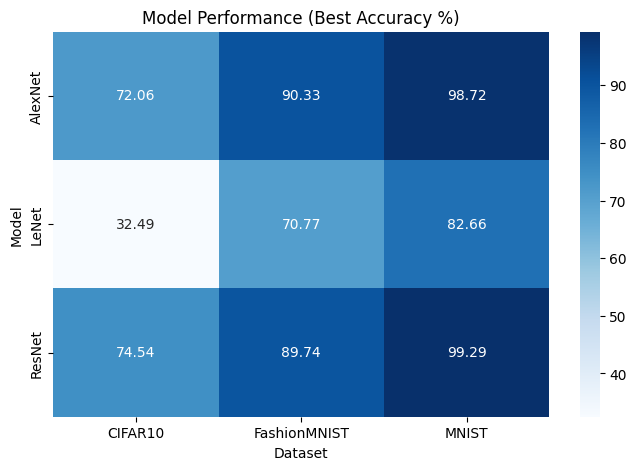

In [48]:
results_df = pd.DataFrame(results)
print("\n📊 Final Results Summary:")
print(results_df)

# Pivot for heatmap
pivot_df = results_df.pivot(index="Model", columns="Dataset", values="Best Accuracy")

plt.figure(figsize=(8,5))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Model Performance (Best Accuracy %)")
plt.show()

# CNN Model Performance Analysis

## 📊 Experimental Results

### **Accuracy Comparison of CNN Models on Different Datasets**

| Model   | MNIST (%) | FashionMNIST (%) | CIFAR-10 (%) |
|---------|-----------|-----------------|--------------|
| LeNet   | 82.66     | 70.77           | 32.49        |
| AlexNet | 98.72     | 90.33           | 72.06        |
| ResNet  | 99.29     | 89.74           | 74.54        |

---

### **Observations**
- **MNIST**: All models perform well, with **ResNet** slightly outperforming others.
- **FashionMNIST**: AlexNet and ResNet show similar performance; LeNet lags behind.
- **CIFAR-10**: ResNet and AlexNet significantly outperform LeNet due to the dataset's complexity and color channels.

---

## 📈 Conclusion and Analysis

1. **Model Performance by Dataset**
   - **MNIST**: Simple grayscale digits → shallow models like LeNet are sufficient, but deeper models (AlexNet, ResNet) achieve higher accuracy.
   - **FashionMNIST**: Slightly more complex grayscale images → LeNet struggles, deeper architectures handle patterns better.
   - **CIFAR-10**: Complex colored images → deeper CNNs with more parameters (AlexNet, ResNet) outperform shallow LeNet by a large margin.

2. **Impact of Dataset Complexity and Model Depth**
   - Simple datasets → small networks can achieve reasonable accuracy.
   - Complex datasets → deeper networks with more convolutional layers and feature extractors generalize better.

3. **Potential Improvements**
   - Hyperparameter tuning: learning rate, batch size, optimizer selection.
   - Data augmentation: flipping, cropping, color jitter to improve CIFAR-10 performance.
   - Regularization techniques: dropout, weight decay to avoid overfitting.
   - Transfer learning for small datasets: fine-tuning pre-trained models like ResNet.

4. **Summary**
   - **MNIST** → ResNet slightly better, but LeNet is adequate.  
   - **FashionMNIST** → AlexNet or ResNet preferred.  
   - **CIFAR-10** → ResNet > AlexNet >> LeNet; deep models required for complex RGB images.
